In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
from importlib import reload
import themachinethatgoesping as ping
import themachinethatgoesping.gridding as grd
import numpy as np
from time import time
reload(grd)


<module 'themachinethatgoesping.gridding' from '/ssd/src/themachinethatgoesping/themachinethatgoesping/subprojects/meta/..//gridding/python/themachinethatgoesping/gridding/__init__.py'>

In [2]:
size=1000000

sx = np.random.random(size)*100
sy = np.random.random(size)*100
sz = np.random.random(size)*100
sv = np.random.random(size)*1

In [3]:
def get_minmax(sx,sy,sz):
    return np.min(sx),np.max(sx), np.min(sy),np.max(sy), np.min(sz),np.max(sz)

In [4]:
reload(ping)
%timeit -n 1 -r 1  ping.gridding.functions.gridfunctions.get_minmax(sx,sy,sz);
%timeit -n 1 -r 1  get_minmax(sx,sy,sz);

157 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
import gc
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100
close_plots = True


def create_figure(name):
    if close_plots: plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name
    
    return fig


In [6]:
#get min and max from xyz vectors
minmax_xyz = grd.ForwardGridder.get_minmax(
    sx = sx,
    sy = sy,
    sz = sz)

print(minmax_xyz)

(2.286177369636988e-06, 99.99997112135198, 1.0388105564640426e-05, 99.99996115677494, 0.00017764995342561818, 99.9998278590636)


In [7]:
#initialize gridder
grid_res = 1

gridder = grd.ForwardGridder.from_data(grid_res,sx,sy,sz)

t1 = time()
ival, iweight = gridder.interpolate_block_mean(sx,sy,sz,sv)
t2 = time()
print(round(t2-t1,3),'s')
ival, iweight = gridder.interpolate_weighted_mean(sx,sy,sz,sv)
print(round(time()-t2,3),'s')

0.225 s
0.831 s


In [8]:
ival.shape

(101, 101, 101)

In [9]:
#convert to a scattergrid for convenience
egrd = grd.EchoGrid(ival,iweight,gridder)
result_image = egrd.get_image(toDb=True,minDbVal=-50) #this is the image you want
total_sv = egrd.total_value #this is the total backscattering cross-section
total_sv_layer = egrd.total_value_layer #about this we talk when you do layer slicing
print(total_sv)

514564.9508744794


In [11]:
egrd = egrd.cut_by_layer_size(40,10)
result_image = egrd.get_image(toDb=True,minDbVal=-50) #this is the image you want
total_sv = egrd.total_value #this is the total backscattering cross-section
total_sv_layer = egrd.total_value_layer #about this we talk when you do layer slicing
print(total_sv)
print(total_sv_layer)

51177.60581315316
51236.94773294367


In [12]:
#sum voxels
map_image_layer = np.nansum(egrd.get_image(toDb=False),axis=2)*gridder.xres*gridder.yres*gridder.zres
np.nansum(map_image_layer)

np.float64(51177.60581315316)

In [13]:
#sum pixels
map_image_layer_vertical = np.nanmean(egrd.image_avg, axis=2)*gridder.xres * gridder.yres * egrd.ZDiff
np.nansum(map_image_layer_vertical)

np.float64(51236.94773294367)

In [14]:
cmap = 'YlGnBu'

-39.37886547751905 -0.007094806845631414


interactive(children=(FloatSlider(value=-20.0, description='cmin', max=0.0, min=-40.0, step=0.5), Checkbox(val…

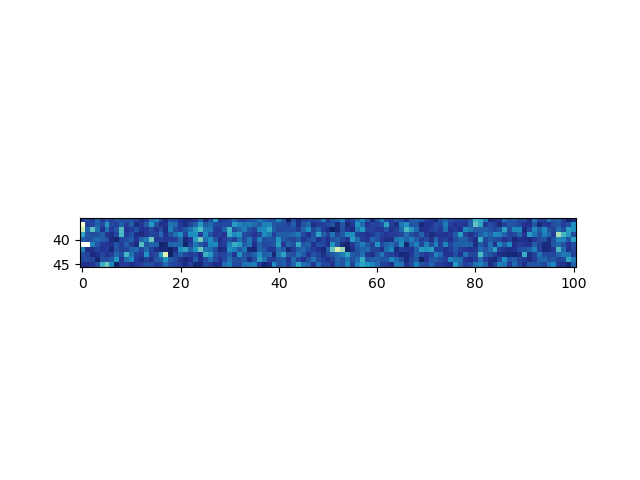

In [16]:
#plot scatter grid

from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import math

#get min max
image = egrd.image_avg.copy()
image[egrd.image_nums == 0] = np.nan
image[image==0] = np.nan
tmp = 10 * np.log10(image)
egrdCmin = np.nanmin(tmp)
egrdCmax = np.nanmax(tmp)
print(egrdCmin,egrdCmax)

fig_slices = create_figure('axes sum')

def update(cmin = (math.floor(egrdCmin),
                   math.ceil(egrdCmax),
                  0.5),
          show_indices=False,
           show_colorbar=False,
           wci_index=(-1,egrd.image_avg.shape[0]-1),
           echo_index=(-1,egrd.image_avg.shape[1]-1),
           depth_index=(-1,egrd.image_avg.shape[2]-1),
           show_wci=True,
           show_echo=False,
           show_map=False):
            
    if wci_index == -1: wci_index = None
    if echo_index == -1: echo_index = None
    if depth_index == -1: depth_index = None
    
    global fig_slices, local_image
    
    try:
        
        fig_slices, ax, local_image = egrd.plot(
            fig_slices,
            show_wci  = show_wci,
            show_echo = show_echo,
            show_map  = show_map,
            show_colorbar = show_colorbar,
            toDb      = True,
            minDbVal  = cmin,
            xindex = wci_index,
            yindex = echo_index,
            zindex = depth_index,
                kwargs={
                    'cmap' : cmap,
                    #'vmin' : egrdCmin,
                    'vmax' : egrdCmax
                },
            colorbar_kwargs = {
                'orientation' : 'horizontal'
            }
        )
    except Exception as e:
        print(e)
        pass
    
    grd = egrd.getGridder()
    
    
    if wci_index is not None:
        wci_index_m   = grd.get_x_value(wci_index)    
    if echo_index is not None:
        echo_index_m  = grd.get_y_value(echo_index)
    if depth_index is not None:
        depth_index_m = grd.get_z_value(depth_index)

    axes = iter(fig_slices.get_axes())
    if show_wci:
        ax = next(axes)        
        if show_indices:
            if depth_index is not None and show_map:
                ax.plot(grd.get_extent_y(),[depth_index_m,depth_index_m],c='grey',linewidth=2)
            if echo_index is not None and show_echo:
                ax.plot([echo_index_m,echo_index_m],grd.get_extent_z(),c='grey',linewidth=2)
        
    if show_echo:
        ax = next(axes)
            
        if show_indices:
            if wci_index is not None and show_wci:
                ax.plot([wci_index_m,wci_index_m],grd.get_extent_z(),c='grey',linewidth=2)
            if depth_index is not None and show_map:
                ax.plot(grd.get_extent_x(),[depth_index_m,depth_index_m],c='grey',linewidth=2)
    if show_map:
        ax = next(axes)
        if show_indices:
            if wci_index is not None and show_wci:
                ax.plot(grd.get_extent_x(),[wci_index_m,wci_index_m],c='grey',linewidth=2)
            if echo_index is not None and show_echo:
                ax.plot([echo_index_m,echo_index_m],grd.get_extent_y(),c='grey',linewidth=2)
    
            
   
    fig_slices.canvas.draw_idle()
    #fig.savefig("../fig_yz.svg",dpi=300)
    
    

interact(update);